In [4]:
import torch
import sklearn
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import config as c
from evaluate import get_anomaly_score
from model import load_model
from utils import get_random_transforms, get_fixed_transforms
from os import listdir
from os.path import join
import pandas as pd 
import random

In [1]:
model_name = 'insulator_detector'
image_folders = ["./insulator_anomaly_data/insulator/test/good", "./insulator_anomaly_data/insulator/test/anomaly"]

Generating the results and saving in csv format

In [2]:
def new_evaluate(model_name, image_folder, fixed_transforms=True):
    model = load_model(model_name)
    files = listdir(image_folder)

    if len(files) > 400:
        files = random.sample(files, 400)

    results = {}

    if fixed_transforms:
        fixed_degrees = [i * 360.0 / c.n_transforms_test for i in range(c.n_transforms_test)]
        transforms = [get_fixed_transforms(fd) for fd in fixed_degrees]
    else:
        transforms = [get_random_transforms()] * c.n_transforms_test

    for f in files:
        image_path = join(image_folder, f)
        score = get_anomaly_score(model, image_path , transforms)
        print(image_path, score)
        if "good" in image_folder:
            results[f] = [score, 0]
        else:
            results[f] = [score, 1]
    
    return results


In [5]:
results = {}
for image_folder in image_folders:
    results.update(new_evaluate(model_name, image_folder))

/workspaces/differnet-inspection/model.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path)


./insulator_anomaly_data/insulator/test/good/Fotos 02-12-2020_DJI_0236_cadeia_isolador_vidro_534.jpg 0.8735858798027039
./insulator_anomaly_data/insulator/test/good/Fotos 16-12-2020_DJI_0514_cadeia_isolador_1334.jpg 0.891122043132782
./insulator_anomaly_data/insulator/test/good/Fotos 16-12-2020_DJI_0563_cadeia_isolador_1269.jpg 0.843386709690094
./insulator_anomaly_data/insulator/test/good/Fotos 22-10-2020_DJI_0648_manilha_isolador_inferior_1332.jpg 0.7754266858100891
./insulator_anomaly_data/insulator/test/good/Fotos 08-12-2020_DJI_0391_manilha_isolador_vidro_inferior_97.jpg 0.8353727459907532
./insulator_anomaly_data/insulator/test/good/Fotos 20-10-2020_DJI_0063_manilha_isolador_inferior_1114.jpg 0.8900661468505859
./insulator_anomaly_data/insulator/test/good/Fotos 23-11-2020_DJI_0295_cadeia_isolador_2584.jpg 0.852205753326416
./insulator_anomaly_data/insulator/test/good/Fotos 14-12-2020_DJI_0507_cadeia_isolador_682.jpg 0.9106731414794922
./insulator_anomaly_data/insulator/test/good/

In [6]:
df = pd.DataFrame.from_dict(results, orient='index', columns=['anomaly_score', 'label'])
df.to_csv(f'./model_results/{model_name}.csv')

Evaluating the results 

In [7]:
df = pd.read_csv(f'./model_results/{model_name}.csv')
df['anomaly_score'] = df['anomaly_score'].round(2)
df_good = df[df['label'] == 0]
df_anomaly = df[df['label'] == 1]

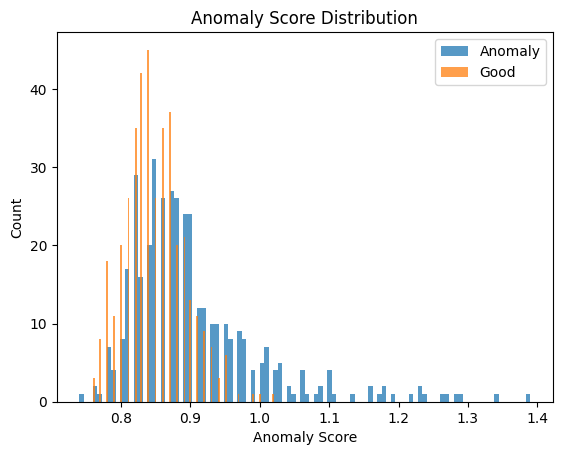

In [9]:
plt.hist(df_anomaly['anomaly_score'], bins=100, alpha=0.75, label='Anomaly')
plt.hist(df_good['anomaly_score'], bins=100, alpha=0.75, label='Good')
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()

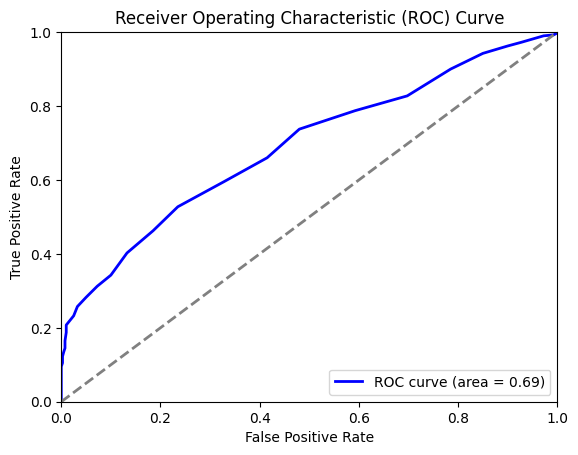

AUROC: 0.6904312499999999


In [10]:
anomaly_scores = df['anomaly_score']
ground_truths = df['label']

fpr, tpr, thresholds = roc_curve(ground_truths, anomaly_scores)

auroc = roc_auc_score(ground_truths, anomaly_scores)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auroc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print(f"AUROC: {auroc}")